# Data relating to figure 4 in Rowland et al
This notebook will reproduce main figure 4 and related text/supplement. The core concepts are described by Tang et al., 2014

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *
from postgres_analysis_helpers.circstat_functions import *
# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))
import pycircstat as pycircstat
import scipy as scipy
from scipy.stats import mannwhitneyu

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data
Loaded postgres_analysis_helpers -> circstat_functions


In [2]:
# Database connection check
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Woot! Database connection is established!')

Connecting to the PostgreSQL database...
Woot! Database connection is established!


In [3]:
dataPile = pd.DataFrame() # create empty dataframe or feed in a base dataframe from before! 
psql = psql_neuroballs(dataPile) # initialize retrieval

83 animals across 5 experimenters found.
Total # of sessions: 9202 (unique clusters: 16314)


In [4]:
psql = psql_neuroballs(dataPile) # initialize retrieval
dict_ = {'phase_tuning_tb': ('bins_angle_center_phase', 'hist_angle_smooth_phase', 'phase_stats_MVL', 'phase_stats_mean', 'phase_stats_var', 'rayleigh_p', 'spike_trig_lfp'),\
         'hd_tuning_tb': ('bins_angle_center', 'hist_angle_smooth', 'tc_stats_MVL', 'tc_stats_mean', 'tc_stats_var'), \
         'ratemaps_tb': ('masked_ratemap',), \
         'BNT_tb_screen': ('InformationContent_bnt', 'tc_stats_hd_peakrate_bnt', 'tc_stats_mean_direction_bnt', 'peak_rate_bnt', 'gridstats_spacing_bnt', 'borderscore_bnt', 'InformationRate_bnt', 'speedscore_bnt', 'tc_stats_peakdirection_bnt', 'tc_stats_mvl_bnt', 'coherence_bnt', 'grid_score_bnt', 'sparsity_bnt', 'theta_strength_bnt', 'selectivity_bnt', 'mean_rate_bnt', 'theta_mean_phase_bnt', 'masked_ratemap_bnt', 'autocorr_bnt', 'occupancy_map_bnt', 'hist_angle_smooth_bnt', 'bins_angle_center_bnt','calbindin_bnt','angular_stability_bnt','peak_rate_bnt','calbindin_dist_bnt'),\
         'st_autocorr_tb': ('burst_idx2','burst_idx1',),\
        }





animals_ = ['7898','7945','70110','70113','70114','54417','T4681','T4932','T4683','T4743','T4935']
filter_ = "AND session_name NOT LIKE '%lase%'"
dataPile = psql.retrieve_data(dict_,animals_,filter_)

83 animals across 5 experimenters found.
Total # of sessions: 9202 (unique clusters: 16314)
1393 entries retrieved.


## check which variables are in the dataframe 
this will give an overview of the variables in the dataframe. 

In [5]:
dataPile.columns

Index(['n_drive_user', 'tetrode_no', 'session_ts', 'animal_id', 'session_name',
       'cluster_no', 'bins_angle_center_phase', 'hist_angle_smooth_phase',
       'phase_stats_mvl', 'phase_stats_mean', 'phase_stats_var', 'rayleigh_p',
       'spike_trig_lfp', 'bins_angle_center', 'hist_angle_smooth',
       'tc_stats_mvl', 'tc_stats_mean', 'tc_stats_var', 'masked_ratemap',
       'informationcontent_bnt', 'tc_stats_hd_peakrate_bnt',
       'tc_stats_mean_direction_bnt', 'peak_rate_bnt', 'gridstats_spacing_bnt',
       'borderscore_bnt', 'informationrate_bnt', 'speedscore_bnt',
       'tc_stats_peakdirection_bnt', 'tc_stats_mvl_bnt', 'coherence_bnt',
       'grid_score_bnt', 'sparsity_bnt', 'theta_strength_bnt',
       'selectivity_bnt', 'mean_rate_bnt', 'theta_mean_phase_bnt',
       'masked_ratemap_bnt', 'autocorr_bnt', 'occupancy_map_bnt',
       'hist_angle_smooth_bnt', 'bins_angle_center_bnt', 'calbindin_bnt',
       'angular_stability_bnt', 'calbindin_dist_bnt', 'burst_idx2',
     

## A little necessary cleanup of the dataframe 

In [6]:
dataPile2 = dataPile.dropna(axis=0, how='any')

In [7]:
new_column = []
for i in range(len(dataPile2)):
    mj = dataPile2.theta_mean_phase_bnt.iloc[i]
    if np.isscalar(mj)== True:
        new_column.append(mj) 
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
dataPile2['theta_mean_phase_bnt_single'] = new_column

new_column = []
for i in range(len(dataPile2)):
    mj = dataPile2.theta_strength_bnt.iloc[i]
    if np.isscalar(mj) == True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
dataPile2['theta_strength_bnt_single'] = new_column

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Make a dataframe for the two putative cell types plus another for cells that fall into the guard zone  
The following sections rely heavily on the classifier developed by Tang et al. The core idea is that pyramidal and stellate cells differ in their theta phase preference and can be separated on the basis of their prefered theta phase and depth of theta modulation. Correspondingly, their analysis showed that grid cells and border cells also clustered the same plots. Here we examine this classifier on our dataset.

In [8]:

calbindin = dataPile2[(dataPile2.calbindin_bnt == 1)&(np.fabs(dataPile2.calbindin_dist_bnt)>=0.1)]
stellate = dataPile2[(dataPile2.calbindin_bnt == 0)&(np.fabs(dataPile2.calbindin_dist_bnt)>=0.1)]
rest =dataPile2[np.fabs(dataPile2.calbindin_dist_bnt)<0.1]

## Now start looking at the data 

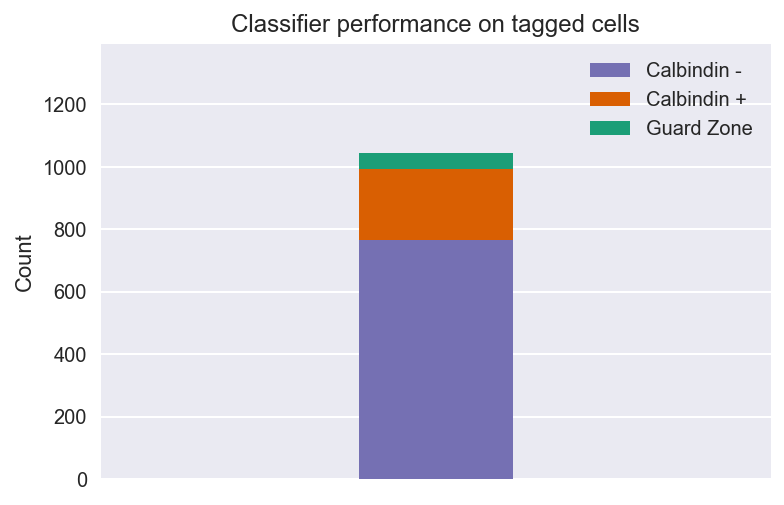

226
766


In [9]:
cb = len(calbindin)
st = len(stellate)
r = len(rest)
width = 0.23
ind = 1
p1 = plt.bar(ind, st, width, color='#7570b3')
p2 = plt.bar(ind, cb, width, color='#d95f02', bottom=st)
p3 = plt.bar(ind, r,width,color='#1b9e77',bottom=[cb+st])

#plt.xticks(ind, ('Tagge', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_xaxis().set_ticks([])

plt.legend((p1[0], p2[0],p3[0]), ('Calbindin -', 'Calbindin +', 'Guard Zone'))
plt.ylim(0,len(dataPile))
plt.xlim(0.5,1.5)
plt.title('Classifier performance on tagged cells')
plt.ylabel('Count')
sns.despine(left=True,bottom=True)
plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_classifier', format='png', dpi=1000)
plt.show()
print(cb)
print(st)

## Plot the data around a circle, color coded by putative cell type
here is the result of the classifier

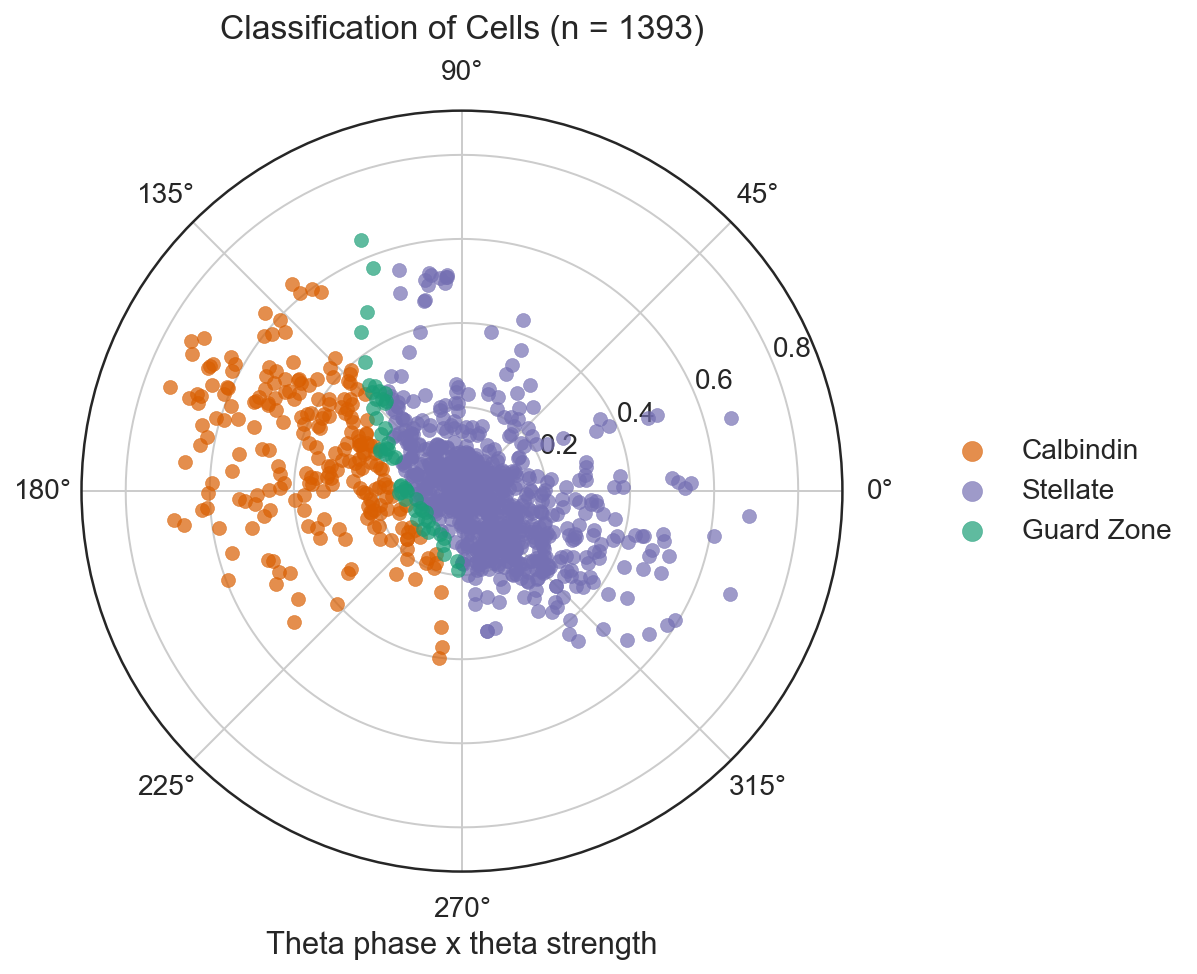

In [10]:
# plot
# scatter 
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin')
ax.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate')
ax.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label='Guard Zone')
ax.set_xlabel('Theta phase x theta strength')
plt.title('Classification of Cells (n = 1393)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength all.svg', format='eps', dpi=1000, bbox_inches='tight')

plt.show()






### Same but for grid cells only. Make marker size proportional to grid score to visually check for trends in the data

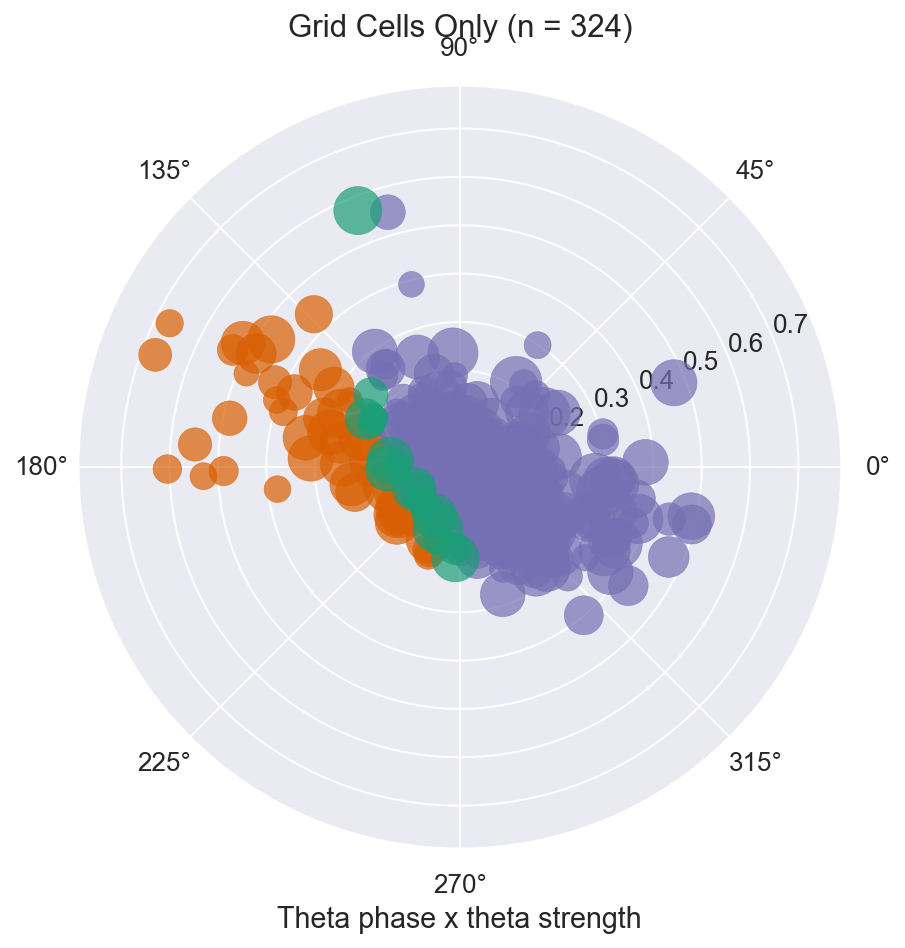

In [11]:
sns.set(font_scale=1.3)
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
calbindinGC = calbindin[calbindin.grid_score_bnt > 0.2980]
stellateGC = stellate[stellate.grid_score_bnt > 0.2980]
restGC =rest[rest.grid_score_bnt > 0.2980]
ax.scatter(calbindinGC.theta_mean_phase_bnt_single.values.astype(float),calbindinGC.theta_strength_bnt_single.values.astype(float),c='#d95f02',s=(calbindinGC.grid_score_bnt*500).astype(int),alpha=.7,label='Calbindin')
ax.scatter(stellateGC.theta_mean_phase_bnt_single.values.astype(float),stellateGC.theta_strength_bnt_single.values.astype(float),c='#7570b3',s=(stellateGC.grid_score_bnt*500).astype(int),alpha=.7,label='Stellate')
ax.scatter(restGC.theta_mean_phase_bnt_single.values.astype(float),restGC.theta_strength_bnt_single.values.astype(float),c='#1b9e77',s=(restGC.grid_score_bnt*500).astype(int),alpha=.7,label='Unclassified')
ax.set_xlabel('Theta phase x theta strength')
plt.title('Grid Cells Only (n = 324)')




In [12]:
len(calbindinGC) +len(stellateGC) +len(restGC)

319

### unwrap the plots to make them a bit easier to see

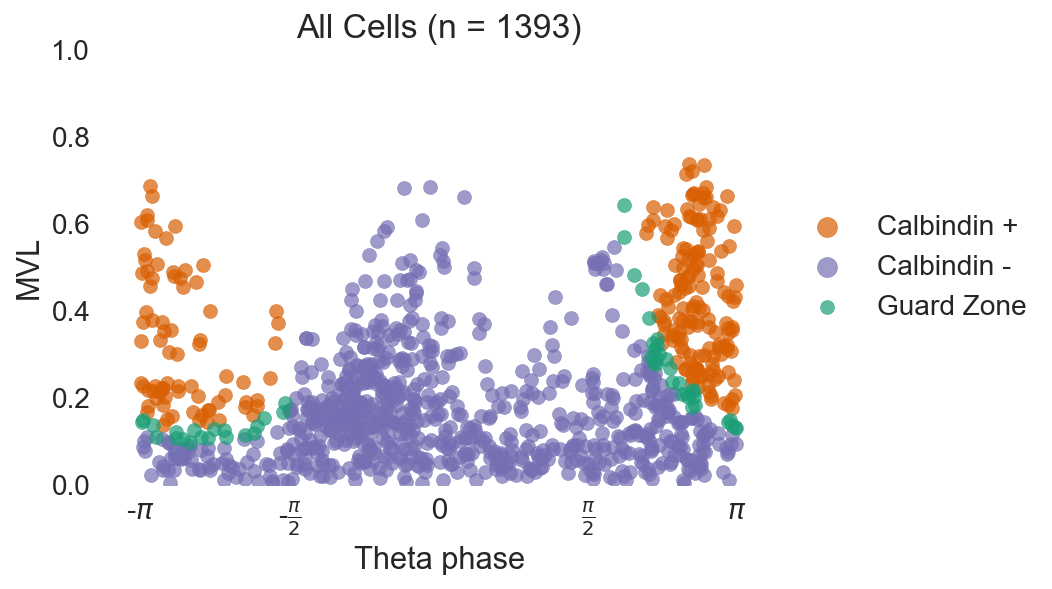

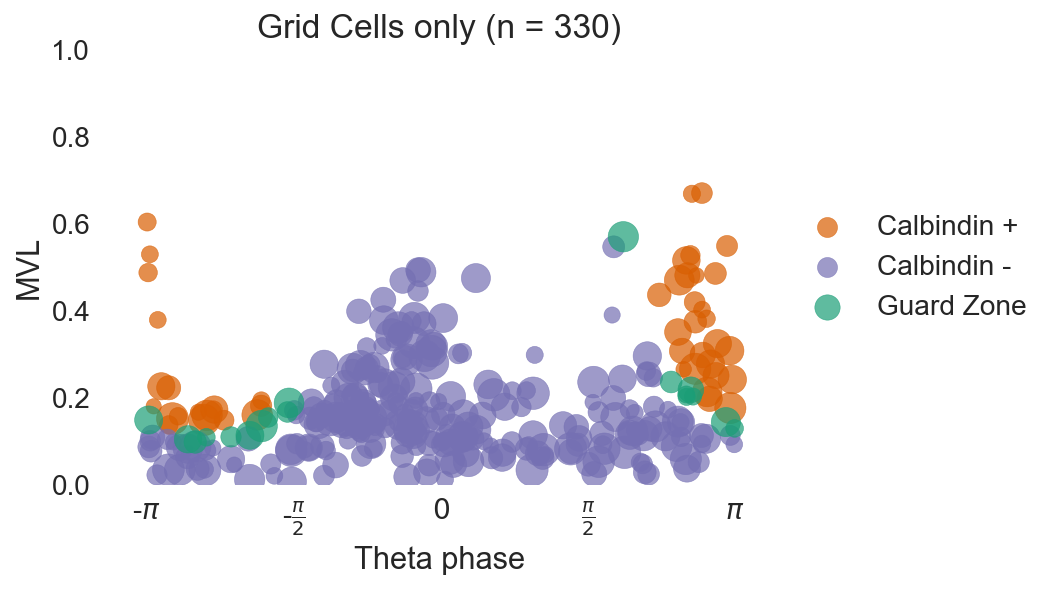

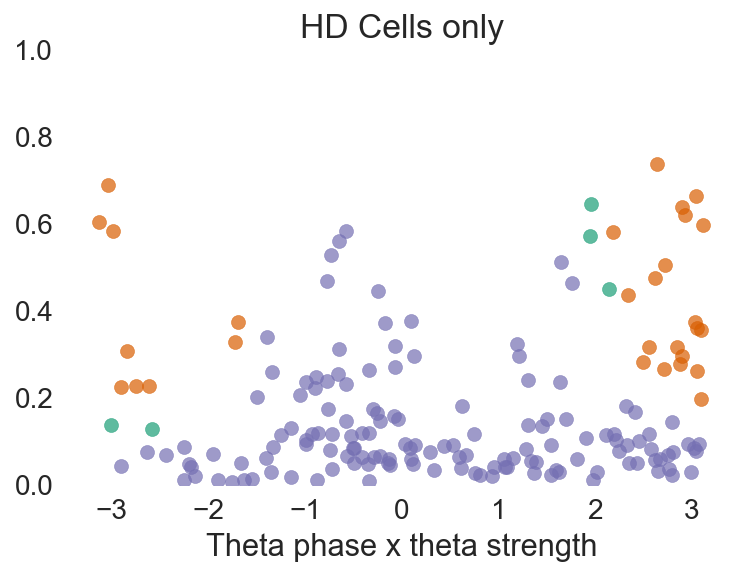

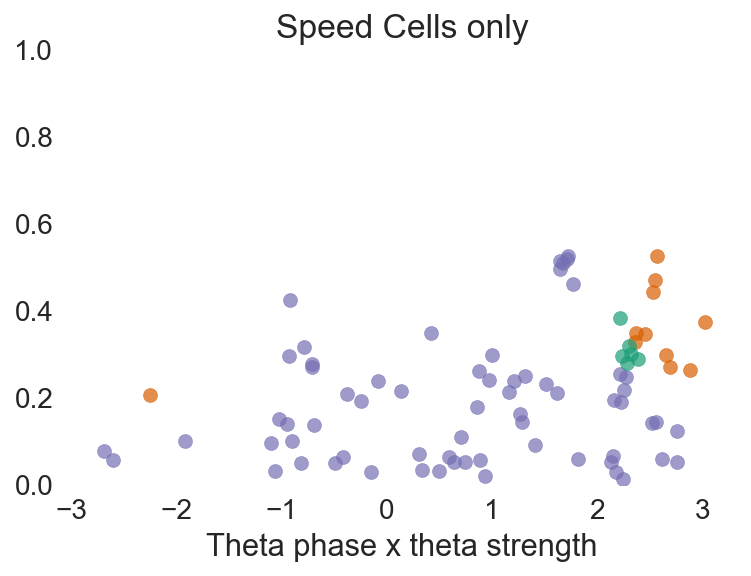

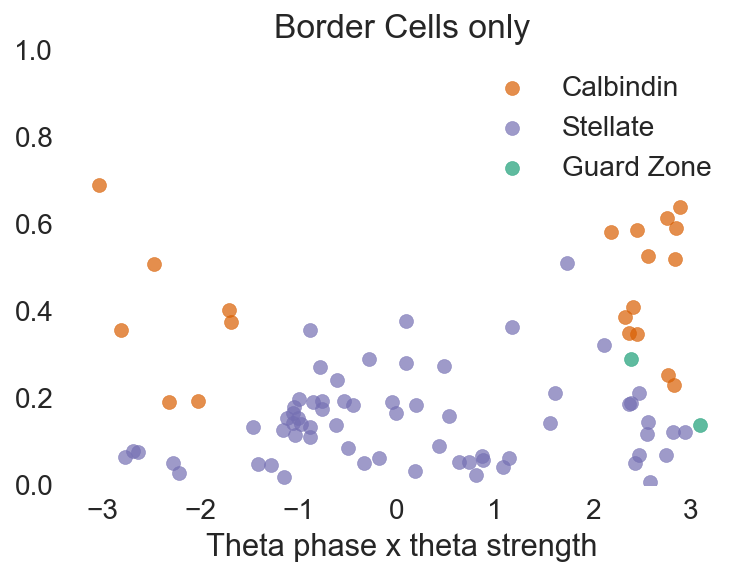

In [13]:
sns.set(font_scale=1.4,style='white')
#ax = figure.add_subplot(1,3,1)
plt.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin +')
plt.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Calbindin -')
plt.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase')
plt.ylabel('MVL')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
plt.ylim([0,1])
pi = np.pi
plt.xticks([-pi, -pi/2, 0, pi/2, pi],
           [r'-$\pi$',r'-$\frac{\pi}{2}$','$0$', r'$\frac{\pi}{2}$', r'$\pi$' ])
plt.title('All Cells (n = 1393)')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\linear phase vs strength all.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()




#ax2 = figure.add_subplot(1,3,3)
plt.scatter(calbindinGC.theta_mean_phase_bnt_single.values.astype(float),calbindinGC.theta_strength_bnt_single.values.astype(float),s=(calbindinGC.grid_score_bnt*200).astype(int),c='#d95f02',alpha=.7,label='Calbindin +')
plt.scatter(stellateGC.theta_mean_phase_bnt_single.values.astype(float),stellateGC.theta_strength_bnt_single.values.astype(float),s=(stellateGC.grid_score_bnt*200).astype(int),c='#7570b3',alpha=.7,label='Calbindin -')
plt.scatter(restGC.theta_mean_phase_bnt_single.values.astype(float),restGC.theta_strength_bnt_single.values.astype(float),s=(restGC.grid_score_bnt*200).astype(int),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase')
plt.ylabel('MVL')
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
#lgnd.legendHandles[2]._sizes = [100]
plt.ylim([0,1])
plt.xticks([-pi, -pi/2, 0, pi/2, pi],
           [r'-$\pi$',r'-$\frac{\pi}{2}$','$0$', r'$\frac{\pi}{2}$', r'$\pi$' ])
plt.title('Grid Cells only (n = 330)')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\linear phase vs strength gcs.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

calbindinHD = calbindin[calbindin.tc_stats_mvl_bnt > 0.2253]
stellateHD = stellate[stellate.tc_stats_mvl_bnt > 0.2253]
restHD =rest[rest.tc_stats_mvl_bnt > 0.2253]

plt.scatter(calbindinHD.theta_mean_phase_bnt_single.values.astype(float),calbindinHD.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin +')
plt.scatter(stellateHD.theta_mean_phase_bnt_single.values.astype(float),stellateHD.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Calbindin -')
plt.scatter(restHD.theta_mean_phase_bnt_single.values.astype(float),restHD.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase x theta strength')
plt.ylim([0,1])
plt.title('HD Cells only')
plt.show()

calbindinSP = calbindin[calbindin.speedscore_bnt > 0.2525]
stellateSP = stellate[stellate.speedscore_bnt > 0.2525]
restSP =rest[rest.speedscore_bnt > 0.2525]

plt.scatter(calbindinSP.theta_mean_phase_bnt_single.values.astype(float),calbindinSP.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin')
plt.scatter(stellateSP.theta_mean_phase_bnt_single.values.astype(float),stellateSP.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate')
plt.scatter(restSP.theta_mean_phase_bnt_single.values.astype(float),restSP.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase x theta strength')
plt.ylim([0,1])
plt.title('Speed Cells only')
plt.show()

calbindinB = calbindin[calbindin.borderscore_bnt > 0.4957]
stellateB = stellate[stellate.borderscore_bnt > 0.4957]
restB =rest[rest.borderscore_bnt > 0.4957]

plt.scatter(calbindinB.theta_mean_phase_bnt_single.values.astype(float),calbindinB.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin')
plt.scatter(stellateB.theta_mean_phase_bnt_single.values.astype(float),stellateB.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate')
plt.scatter(restB.theta_mean_phase_bnt_single.values.astype(float),restB.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase x theta strength')
plt.legend()
plt.ylim([0,1])
plt.title('Border Cells only')
plt.show()



## Now do some comparisons between putative cell types

### grid score first 

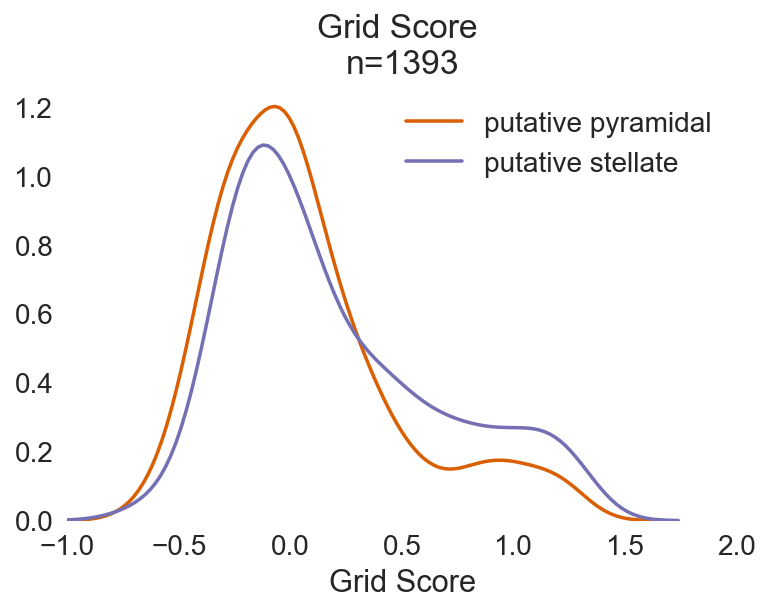

In [14]:
sns.kdeplot(calbindin.grid_score_bnt, shade=False, color="#d95f02",label='putative pyramidal')
sns.kdeplot(stellate.grid_score_bnt, shade=False, color="#7570b3",label='putative stellate')
sns.despine(left=True,bottom=True)
plt.xlabel('Grid Score')

sns.set_style("white")
plt.legend()
label = 'Grid Score \nn={}'.format(len(dataPile))
plt.title(label)
plt.xlim( (-1.0, 2) )
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_kde.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

In [15]:
pycircstat.tests.rayleigh(dataPile2.phase_stats_mean)

(7.0728409832913971e-09, 18.691580203237226)

In [16]:
scipy.stats.mannwhitneyu(calbindin.grid_score_bnt, stellate.grid_score_bnt)

MannwhitneyuResult(statistic=72729.0, pvalue=0.00012928827582738876)

### now border score

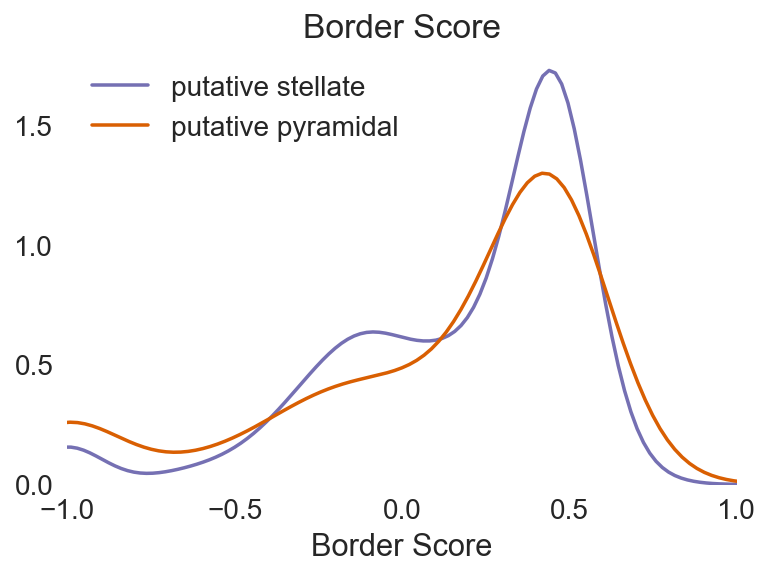

In [17]:
sns.kdeplot(stellate.borderscore_bnt, shade=False, color="#7570b3",label='putative stellate')
sns.kdeplot(calbindin.borderscore_bnt, shade=False, color="#d95f02",label='putative pyramidal')

sns.despine(left=True,bottom=True)
sns.set_style("white")
plt.xlabel('Border Score')
plt.title('Border Score')
plt.legend()
plt.xlim( (-1.0, 1) )
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_kde.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

In [18]:

scipy.stats.mannwhitneyu(calbindin.borderscore_bnt, stellate.borderscore_bnt)

MannwhitneyuResult(statistic=83532.0, pvalue=0.21201773503288474)

In [19]:
np.mean(calbindin.borderscore_bnt)

0.097485535162299505

### Speed score

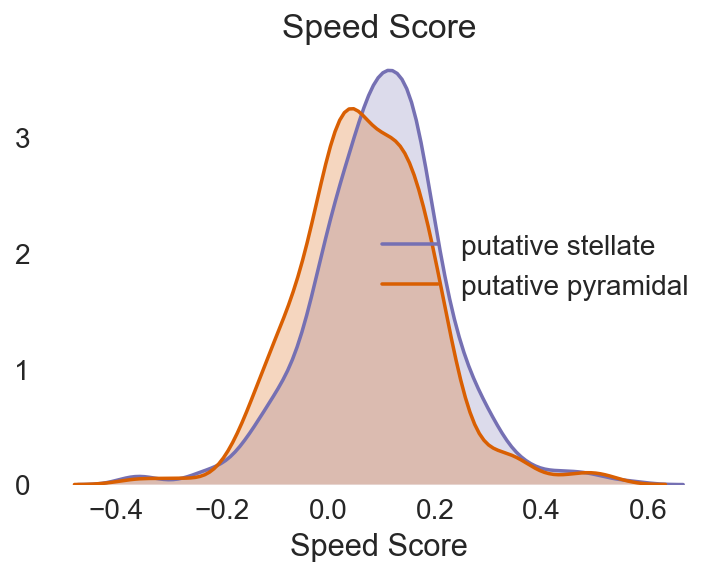

In [20]:
sns.kdeplot(stellate.speedscore_bnt, shade=True, color="#7570b3",label='putative stellate')
sns.kdeplot(calbindin.speedscore_bnt, shade=True, color="#d95f02",label='putative pyramidal')

sns.despine(left=True,bottom=True)
sns.set_style("white")
plt.xlabel('Speed Score')
plt.title('Speed Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_kde.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

In [21]:
scipy.stats.mannwhitneyu(calbindin.speedscore_bnt, stellate.speedscore_bnt)

MannwhitneyuResult(statistic=74806.0, pvalue=0.00095187597357750987)

## Now make stacked bar charts, put. stellate cells first

In [22]:
cells = stellate

In [23]:
# set some thresholds based on the 95% threshold of the shuffled distribution
grid_cutoff =  0.2980
mvl_cutoff = 0.1713
speed_cutoff = 0.1907
spatial_info_cutoff = 0.8204
border_cutoff = 0.5007 

In [24]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(cells.grid_score_bnt <= grid_cutoff) &\
               (cells.tc_stats_mvl <= mvl_cutoff) &\
               (cells.speedscore_bnt <= speed_cutoff) &\
               (cells.borderscore_bnt <= border_cutoff)]

In [25]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [26]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)+len(unstable_HD)
frac_unclas = unclas_len/all_len


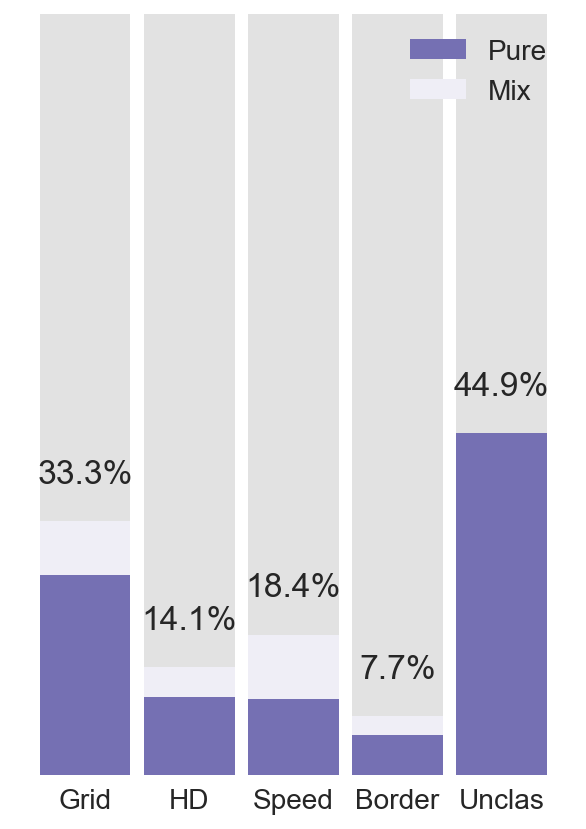

In [27]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()

seq_col_brew = sns.color_palette(sns.light_palette("#7570b3",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
#plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\putstellate_stacked_bar.svg', format='svg', dpi=1000)
plt.show()

### make stacked bars for the put. pyramidal population 

In [28]:
cells = calbindin

In [29]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(cells.grid_score_bnt <= grid_cutoff) &\
               (cells.tc_stats_mvl <= mvl_cutoff) &\
               (cells.speedscore_bnt <= speed_cutoff) &\
               (cells.borderscore_bnt <= border_cutoff)]

In [30]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [31]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)+len(unstable_HD)
frac_unclas = unclas_len/all_len


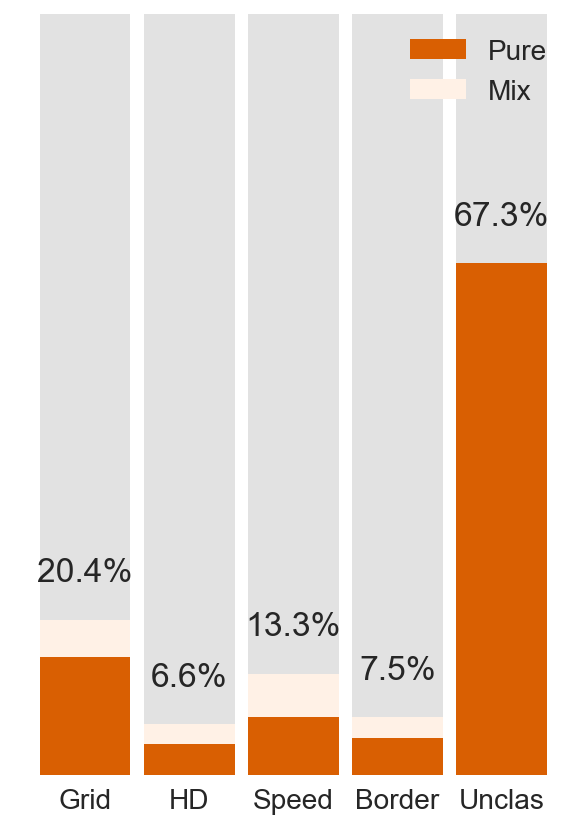

In [32]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()

seq_col_brew = sns.color_palette(sns.light_palette("#d95f02",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
#plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\putcalbindin_stacked_bar.svg', format='svg', dpi=1000)
plt.show()

### Now look at the cells that fall in the guard zone...why not?

In [33]:
rest =dataPile2[np.fabs(dataPile2.calbindin_dist_bnt)<0.1]
cells = rest

In [34]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(cells.grid_score_bnt <= grid_cutoff) &\
               (cells.tc_stats_mvl <= mvl_cutoff) &\
               (cells.speedscore_bnt <= speed_cutoff) &\
               (cells.borderscore_bnt <= border_cutoff)]

In [35]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [36]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)+len(unstable_HD)
frac_unclas = unclas_len/all_len


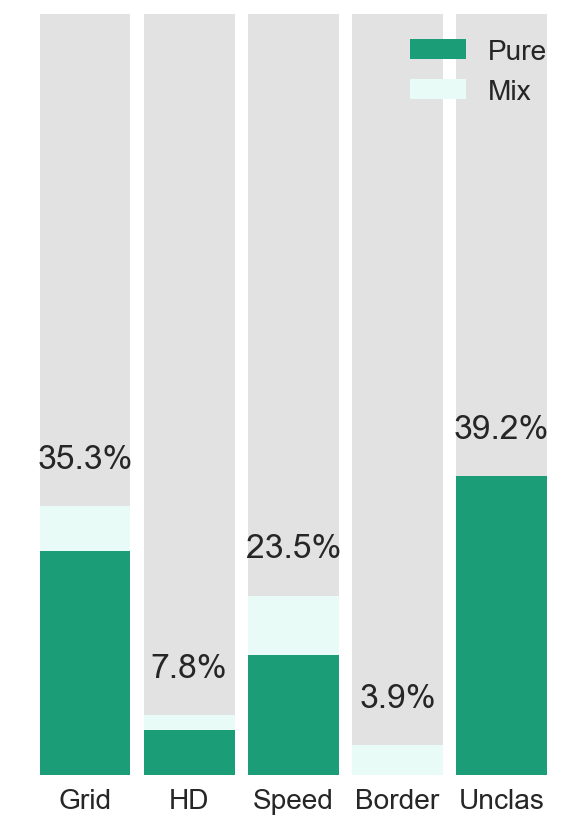

In [37]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()

seq_col_brew = sns.color_palette(sns.light_palette("#1b9e77",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
#plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\putcalbindin_stacked_bar.svg', format='svg', dpi=1000)
plt.show()

## Ignore putative cell type and just look at the theta modulation of different functional cell types 

In [38]:
cells = dataPile2
grid_cutoff =  0.2980
mvl_cutoff = 0.1713
speed_cutoff = 0.1907
spatial_info_cutoff = 0.8204
border_cutoff = 0.5007
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(cells.grid_score_bnt <= grid_cutoff) &\
               (cells.tc_stats_mvl <= mvl_cutoff) &\
               (cells.speedscore_bnt <= speed_cutoff) &\
               (cells.borderscore_bnt <= border_cutoff)]

In [39]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [40]:
ab = []
ab= pd.concat([gridc['phase_stats_mvl'], hdc['phase_stats_mvl'],speedc['phase_stats_mvl'],borderc['phase_stats_mvl']], axis=1)
ab.columns = ['grid', 'HD','Speed', 'Border']

In [41]:
ab = np.array(ab)

In [42]:
test = []
new_column = []

for i in range(len(pure_gridc)):
    new_column.append(1)

# now overwrite previous column:


for i in range(len(pure_borderc)):
    new_column.append(3)

# now overwrite previous column:

for i in range(len(pure_speedc)):
    new_column.append(2)

# now overwrite previous column:

for i in range(len(pure_hdc)):
    new_column.append(4)
test = new_column

test2 = []
new_column2 = []

for i in range(len(pure_gridc)):
    new_column2.append(gridc.iloc[i].phase_stats_mvl)
# now overwrite previous column:


for i in range(len(pure_borderc)):
    new_column2.append(borderc.iloc[i].phase_stats_mvl)

# now overwrite previous column:

for i in range(len(pure_speedc)):
    new_column2.append(speedc.iloc[i].phase_stats_mvl)

# now overwrite previous column:

for i in range(len(pure_hdc)):
    new_column2.append(hdc.iloc[i].phase_stats_mvl)

test2 = new_column2
# now overwrite previous column:
ts1 = np.array(test)
ts2 = np.array(test2)
ts1=np.reshape(ts1,(len(ts1),1))
ts2=np.reshape(ts2,(len(ts2),1))
fk = np.hstack((ts1,ts2))

fku = pd.DataFrame(fk)
fku.columns = ['functional','mvl']

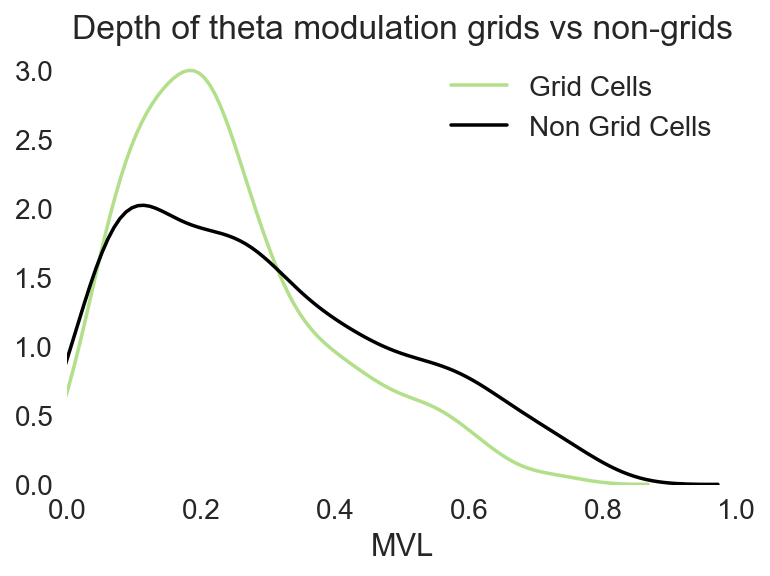

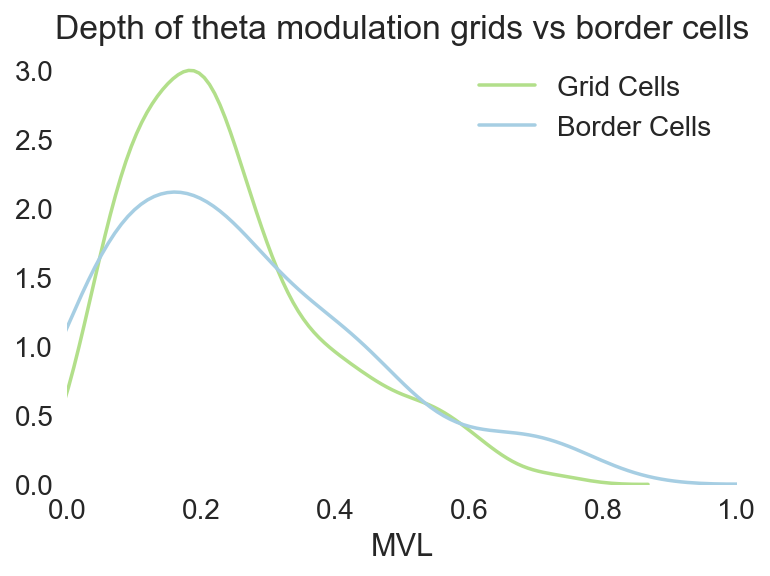

In [43]:
sns.set(font_scale=1.4,style='white')
gcs = dataPile2[dataPile2.grid_score_bnt> 0.2980]
nongcs = dataPile2[dataPile2.grid_score_bnt< 0.2980]
scipy.stats.mannwhitneyu(gcs.phase_stats_mvl, nongcs.phase_stats_mvl)

sns.kdeplot(gcs.phase_stats_mvl, shade=False, color='#b2df8a',label='Grid Cells')
sns.kdeplot(nongcs.phase_stats_mvl, shade=False, color='k',label='Non Grid Cells')
sns.despine(left=True,bottom=True)
plt.xlabel('MVL')
plt.title('Depth of theta modulation grids vs non-grids')
plt.legend()
plt.xlim( (-0, 1) )
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid vs non grid MVL.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()


B = dataPile2[dataPile2.borderscore_bnt > 0.5007]
scipy.stats.mannwhitneyu(gcs.phase_stats_mvl, B.phase_stats_mvl)

sns.kdeplot(gcs.phase_stats_mvl, shade=False, color='#b2df8a',label='Grid Cells')
sns.kdeplot(B.phase_stats_mvl, shade=False, color='#a6cee3',label='Border Cells')
sns.despine(left=True,bottom=True)
plt.xlabel('MVL')
plt.title('Depth of theta modulation grids vs border cells')
plt.xlim( (-0, 1) )
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid vs border MVL.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()


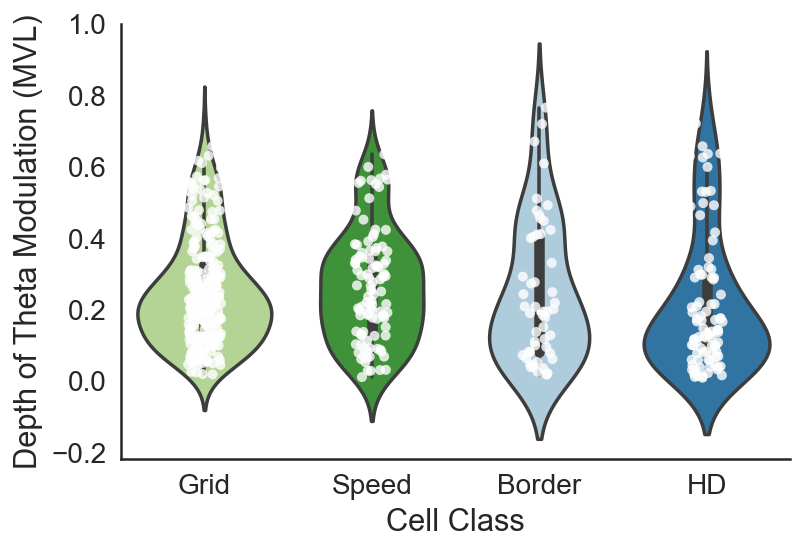

In [44]:
newp =  sns.color_palette(['#b2df8a','#33a02c','#a6cee3','#1f78b4'])
ind = np.arange(4) 
ax = sns.violinplot(x="functional", y="mvl", data=fku, palette=newp,split = True)
ax = sns.stripplot(x="functional", y="mvl", data=fku,color='white', jitter = True, alpha = 0.8)
plt.xlabel('Cell Class')
plt.ylabel('Depth of Theta Modulation (MVL)')
plt.xticks(ind, ('Grid','Speed','Border', 'HD') )
sns.despine()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\theta mod by class.svg', format='svg', dpi=1000)
plt.show()

In [45]:
scipy.stats.mannwhitneyu(gridc.phase_stats_mvl, borderc.phase_stats_mvl)

MannwhitneyuResult(statistic=12193.0, pvalue=0.39263924129398337)

In [46]:
scipy.stats.mannwhitneyu(gridc.phase_stats_mvl, hdc.phase_stats_mvl)

MannwhitneyuResult(statistic=16550.5, pvalue=0.0012790433565040334)

In [47]:
np.mean(gridc.phase_stats_mvl)

0.23923492281993919

In [48]:
scipy.stats.mannwhitneyu(gridc.phase_stats_mvl, speedc.phase_stats_mvl)

MannwhitneyuResult(statistic=27741.0, pvalue=0.17747570912642402)

In [49]:
scipy.stats.mannwhitneyu(borderc.phase_stats_mvl, speedc.phase_stats_mvl)

MannwhitneyuResult(statistic=6979.0, pvalue=0.38892201665065912)

In [50]:
scipy.stats.mannwhitneyu(borderc.phase_stats_mvl, hdc.phase_stats_mvl)

MannwhitneyuResult(statistic=4094.5, pvalue=0.018733532186775446)

In [51]:
scipy.stats.mannwhitneyu(gridc.phase_stats_mvl, nongcs.phase_stats_mvl)


MannwhitneyuResult(statistic=100526.0, pvalue=0.00042573583483504788)

In [52]:
scipy.stats.mannwhitneyu(speedc.phase_stats_mvl, hdc.phase_stats_mvl)

MannwhitneyuResult(statistic=9245.5, pvalue=0.0011083909964703007)

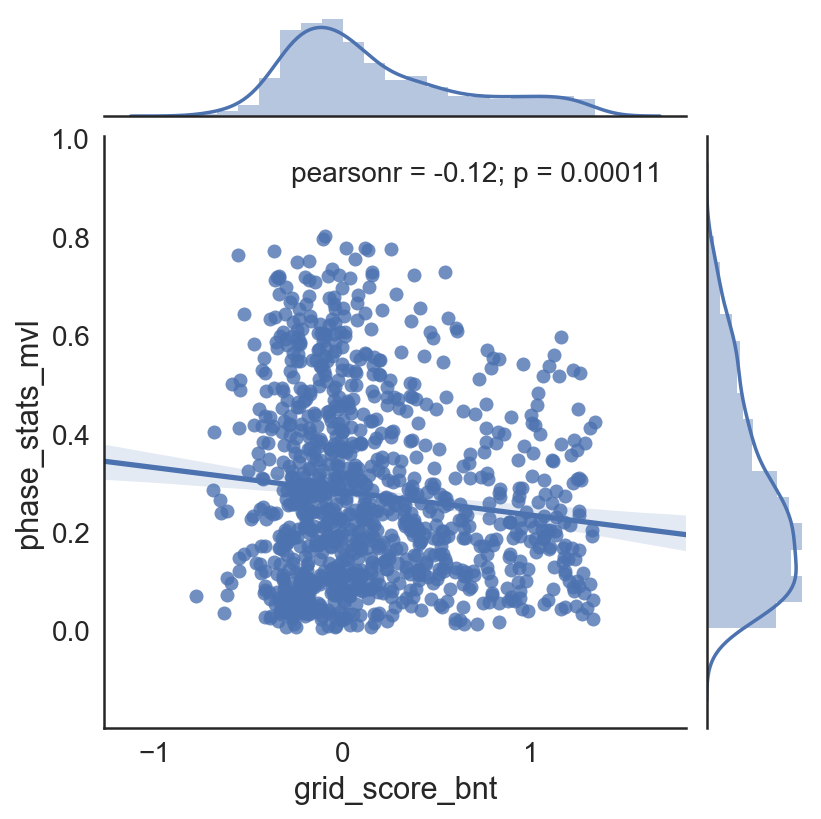

In [53]:
sns.jointplot(x="grid_score_bnt", y="phase_stats_mvl", data=dataPile2, kind="reg")

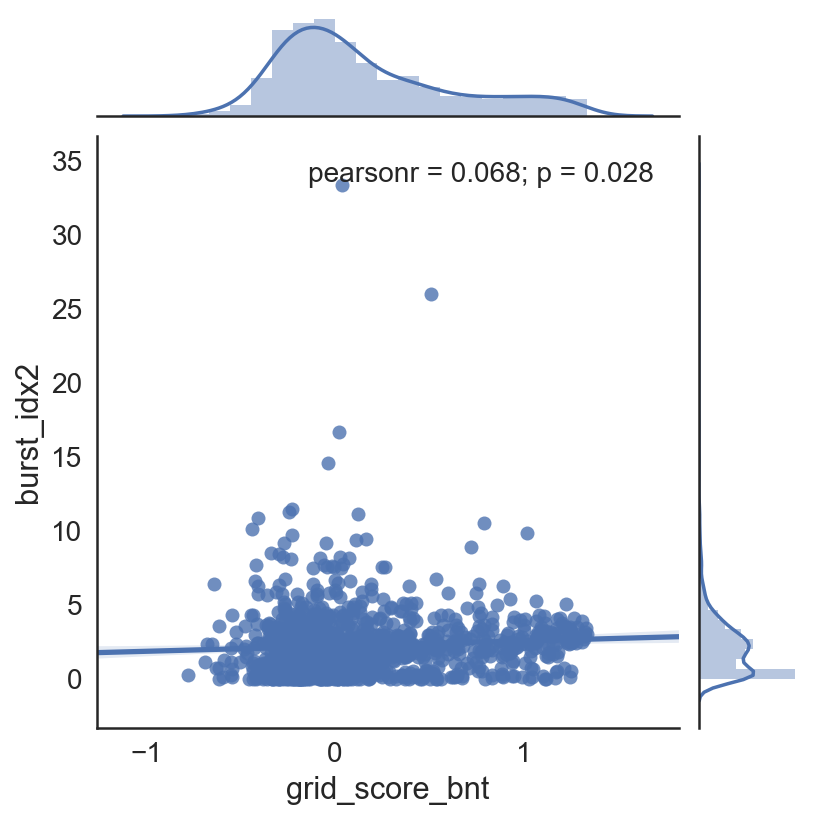

In [54]:
sns.jointplot(x="grid_score_bnt", y="burst_idx2", data=dataPile2, kind="reg")

## Try a second clustering approach
This is a cruder way to cluster the data (basically just cuts the data in half) but the point was to see if slicing up the data in a different way made a difference (i.e if we would catch functional cell types using a different approach). Based on the distributions above, it was very unlikely that that would happen. Indeed, this analysis did not produce any new insights.  

In [55]:
cl= pycircstat.clustering.AggCluster1D(numclust=2)#clustering from the circstat tool box, fix the number of clusters to 2
_, ids = cl.train(dataPile2.phase_stats_mean)
_, testids = cl.test(dataPile2.phase_stats_mean)

df5 = dataPile2
df5['testids'] = testids

cl0 = dataPile2[df5.testids == 0]
cl1 = dataPile2[df5.testids == 1]

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:189: RuntimeWarning: invalid value encountered in multiply
  return np.angle(np.exp(1j * alpha[reshaper_alpha]) /
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:190: RuntimeWarning: invalid value encountered in multiply
  np.exp(1j * beta[reshaper_beta]))
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(1j * beta[reshaper_beta]))
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### do some plotting of the data
notice that cluster 1 roughly captures a similar population as the putative pyramidal population but with more relaxed borders. 

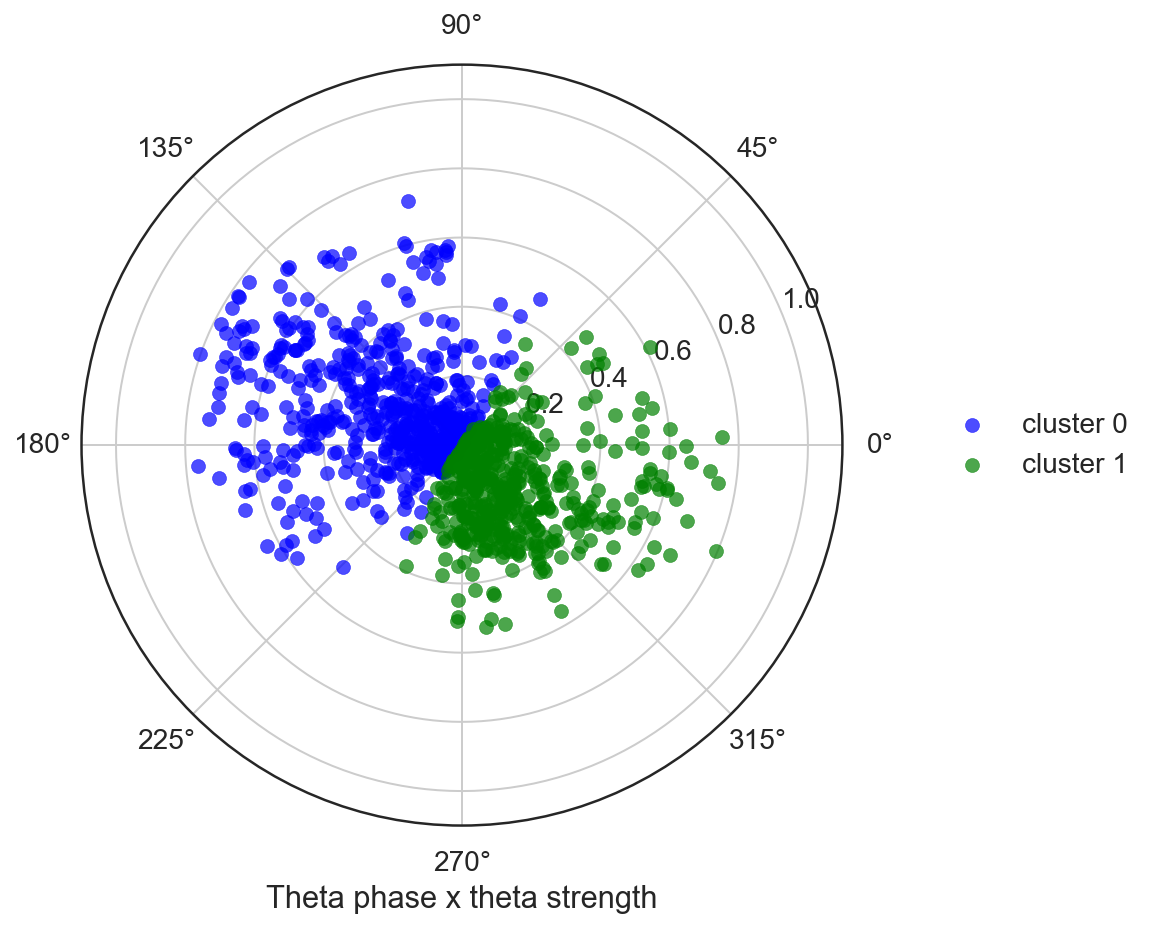

In [56]:
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')

ax.scatter(cl0.phase_stats_mean.values.astype(float),cl0.phase_stats_mvl.values.astype(float),alpha=.7, c = 'b', label = "cluster 0")
ax.scatter(cl1.phase_stats_mean.values.astype(float),cl1.phase_stats_mvl.values.astype(float),alpha=.7, c = 'g', label = "cluster 1")
ax.set_xlabel('Theta phase x theta strength')
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\agg_cluster_circular_dist.svg', format='svg', dpi=1000, bbox_inches='tight')

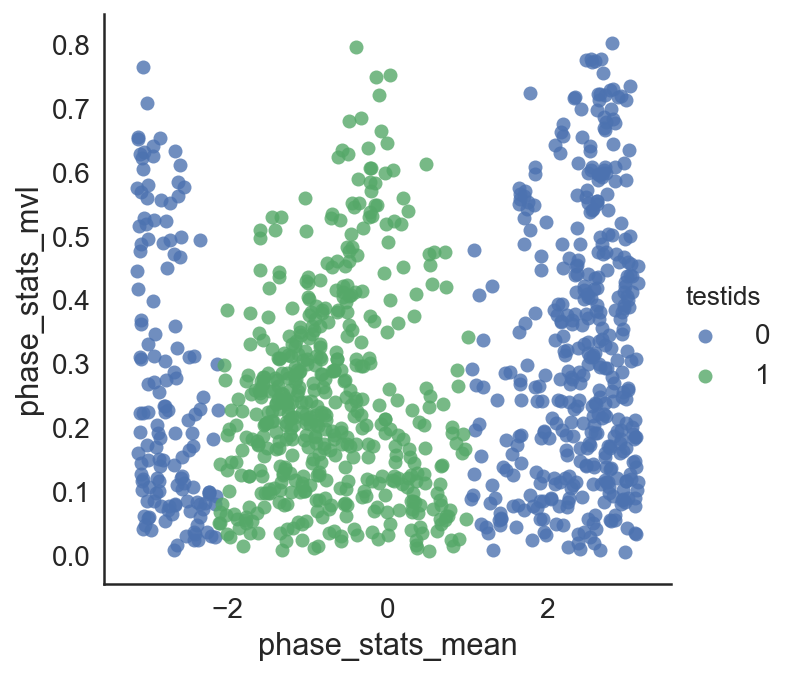

In [57]:
ax = sns.lmplot(x="phase_stats_mean", y="phase_stats_mvl", hue='testids',data=df5,fit_reg=False)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\agg_cluster_results.svg', format='svg', dpi=1000, bbox_inches='tight')

### now do some comparisons between clusters
notice that there are some differences between clusters but both clusters contain all functional cell types, as with the SVM classifier.

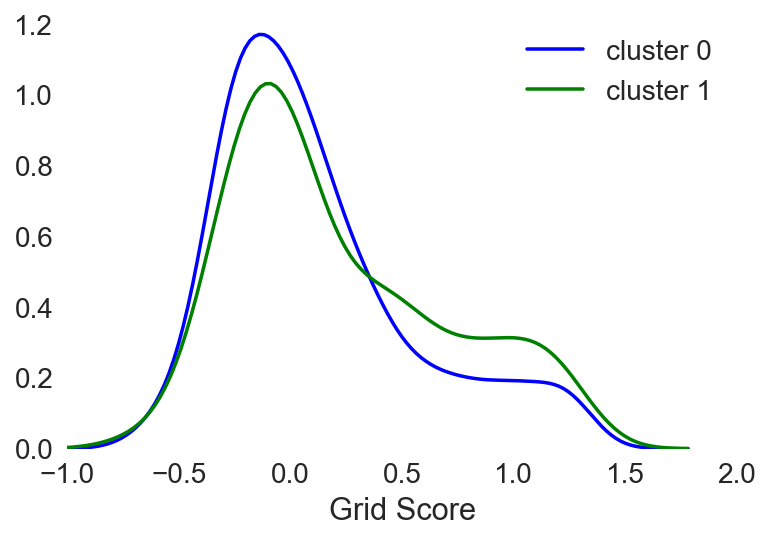

In [58]:
cl0 = dataPile2[df5.testids == 0]
cl1 = dataPile2[df5.testids == 1]
sns.kdeplot(cl0.grid_score_bnt, shade=False, color='b',label='cluster 0')
sns.kdeplot(cl1.grid_score_bnt, shade=False, color='g',label='cluster 1')
sns.despine(left=True,bottom=True)
plt.xlabel('Grid Score')

sns.set_style("white")
plt.legend()
#label = 'Grid Score \nn={}'.format(len(dataPile))
#plt.title(label)
plt.xlim( (-1.0, 2) )
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\agg_cluster_grid_score_kde.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

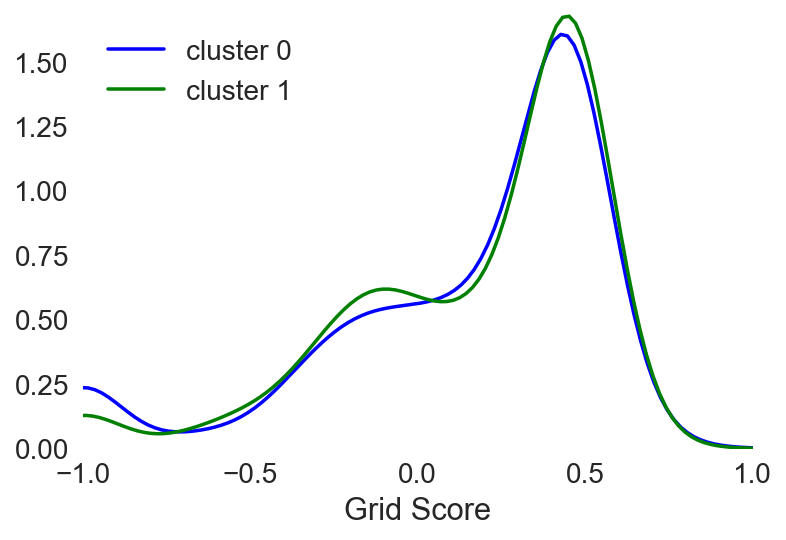

In [59]:
sns.kdeplot(cl0.borderscore_bnt, shade=False, color='b',label='cluster 0')
sns.kdeplot(cl1.borderscore_bnt, shade=False, color='g',label='cluster 1')
sns.despine(left=True,bottom=True)
plt.xlabel('Grid Score')

sns.set_style("white")
plt.legend()
#label = 'Grid Score \nn={}'.format(len(dataPile))
#plt.title(label)
plt.xlim( (-1.0, 1.0) )
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\agg_cluster_border_score_kde.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

In [60]:
scipy.stats.mannwhitneyu(cl0.grid_score_bnt, cl1.grid_score_bnt)

MannwhitneyuResult(statistic=120268.0, pvalue=0.00074480359169975835)

In [61]:
scipy.stats.mannwhitneyu(cl0.borderscore_bnt, cl1.borderscore_bnt)

MannwhitneyuResult(statistic=130268.5, pvalue=0.13161725679301856)

In [62]:
pycircstat.tests.watson_williams(gcs.phase_stats_mean, borderc.phase_stats_mean)

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\tests.py:417: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  'Test not applicable. Average resultant vector length < 0.45.')


(0.032255932458760295,
                  F        MS          SS     df   p-value
 Source                                                   
 Columns   4.617424  1.750154    1.750154    1.0  0.032256
 Residual       NaN  0.857356  338.655774  395.0       NaN
 Total          NaN       NaN  340.405928  396.0       NaN)

In [63]:
np.mean(cl0.grid_score_bnt)

0.11190209678277056

In [64]:
np.mean(cl1.grid_score_bnt)

0.21106618159810789

In [ ]:
pycircstat.tests.vtest(borderc.phase_stats_mean, 0)

(0.81493352090662896, -5.5969192134686168)

In [ ]:
cl= pycircstat.clustering.AggCluster1D(numclust=3)#clustering from the circstat tool box, fix the number of clusters to 3
_, ids = cl.train(dataPile2.phase_stats_mean)
_, testids = cl.test(dataPile2.phase_stats_mean)

df5 = dataPile2
df5['testids'] = testids

cl0 = dataPile2[df5.testids == 0]
cl1 = dataPile2[df5.testids == 1]
cl2 = dataPile2[df5.testids == 2]

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:189: RuntimeWarning: invalid value encountered in multiply
  return np.angle(np.exp(1j * alpha[reshaper_alpha]) /
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:190: RuntimeWarning: invalid value encountered in multiply
  np.exp(1j * beta[reshaper_beta]))
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(1j * beta[reshaper_beta]))


In [ ]:
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')

ax.scatter(cl0.phase_stats_mean.values.astype(float),cl0.phase_stats_mvl.values.astype(float),alpha=.7, c = '#b2df8a', label = "cluster 0")
ax.scatter(cl1.phase_stats_mean.values.astype(float),cl1.phase_stats_mvl.values.astype(float),alpha=.7, c = '#1f78b4', label = "cluster 1")
ax.scatter(cl2.phase_stats_mean.values.astype(float),cl2.phase_stats_mvl.values.astype(float),alpha=.7, c = '#a6cee3', label = "cluster 2")
ax.set_xlabel('Theta phase x theta strength')
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\agg_cluster_circular_dist.svg', format='svg', dpi=1000, bbox_inches='tight')